In [1]:
import numpy as np
from scipy import integrate
import scipy.linalg as lalgebra
import math

import matplotlib.pyplot as plt
import matplotlib.tri as tri

This method is prescribed by Wang and Aung (2007) "Plastic buckling analysis of thick plates using p-Ritz method". International Journal of Solids and Structures, 44(18), 6239–6255.

Defining the function:
 (a) that satisfy the boundary conditions :
$$
 \phi_{support}^{w}({ξ},{η}) = ({ξ}+{1})^{α}({η}+{1})^{β}({ξ}-{1})^{γ}({η}-{1})^{δ}\\
 \phi_{support}^{x}({ξ},{η}) = ({ξ}+{1})^{α}({η}+{1})^{β}({ξ}-{1})^{γ}({η}-{1})^{δ}\\
 \phi_{support}^{y}({ξ},{η}) = ({ξ}+{1})^{α}({η}+{1})^{β}({ξ}-{1})^{γ}({η}-{1})^{δ}
$$

where $α$, $β$, $γ$ and $δ$ took values either 0 or 1 and (b) the base monomial that assemble the polynomials :
$$
\phi_{m1}({ξ},{η}) = {ξ}^r\,{η}^{q}
$$

Recall that the polynomials are assembled of monomials as a product of the base monomial with the functions that satisfy the boundary conditions:
$$
\phi_{m}^{w}({ξ},{η}) = \phi_{support}^{w}({ξ},{η})\,\phi_{m1}({ξ},{η})=\phi_{support}^{w}({ξ},{η})\,{ξ}^r\,{η}^{q-r} \\
\phi_{m}^{x}({ξ},{η}) = \phi_{support}^{x}({ξ},{η})\,\phi_{m1}({ξ},{η})=\phi_{support}^{x}({ξ},{η})\,{ξ}^r\,{η}^{q-r} \\
\phi_{m}^{y}({ξ},{η}) =\phi_{support}^{y}({ξ},{η})\, \phi_{m1}({ξ},{η})=\phi_{support}^{y}({ξ},{η})\,{ξ}^r\,{η}^{q-r}
$$
with
$$
m=\frac{(q+1)(q+2)}{2}-r
$$

In [2]:
##### (a)
def φsupport(ξ, η, powers):
    α, β, γ, δ  = powers
    return (-1 + η)**δ*(1 + η)**β*(-1 + ξ)**γ*(1 + ξ)**α#

def dφsupportdξ(ξ, η, powers):
    α, β, γ, δ  = powers
    return α*(-1 + η)**δ*(1 + η)**β*(-1 + ξ)**γ*(1 + ξ)**(-1 + α) + γ*(-1 + η)**δ*(1 + η)**β*(-1 + ξ)**(-1 + γ)*(1 + ξ)**α#

def dφsupportdη(ξ, η, powers):
    α, β, γ, δ  = powers
    return β*(-1 + η)**δ*(1 + η)**(-1 + β)*(-1 + ξ)**γ*(1 + ξ)**α + δ*(-1 + η)**(-1 + δ)*(1 + η)**β*(-1 + ξ)**γ*(1 + ξ)**α#


#####################################################################################################################################
##### (b)
def φm1(ξ, η, powers):
    q, r  = powers
    return η**q*ξ**r#

def dφm1dξ(ξ, η, powers):
    q, r  = powers
    if(r==0.0):
        return 0.0#
    return r*η**q*ξ**(-1 + r)#

def dφm1dη(ξ, η, powers):
    q, r  = powers
    if(q ==0.0):
        return 0.0#
    return q*η**(-1 + q)*ξ**r#

Defining an the Ritz Unknowns Function object. The object contains information about the polynomial order of the p-Ritz functions and the powers on which the
support equations are raised.

In [3]:
class RitzUnknownsFunction:

    def __init__(self, p, supportFuncPowers):
        self.polynomialOrder = p#
        self.RitzRestraintFunc = supportFuncPowers#
        self.Indexing = []

        for q in range(0,self.polynomialOrder+1):
            for r in range(0,q+1):
              self.Indexing.append([r,q-r])
        return
    
    def GetSupportValue(self, x):
        ξ , η = x #
        return φsupport(ξ, η, self.RitzRestraintFunc)

The user here specifys the polynomial order of p-Ritz function and assigns the powers of the support functions.

In [4]:
OrderOfPoly=12
Deflection=RitzUnknownsFunction(OrderOfPoly,[1,1,1,1])
#print('\nDeflection : \n')
#Deflection.PrintIndexing()
RotX=RitzUnknownsFunction(OrderOfPoly,[0,1,0,1]) # simple support
#print('\nRotX : \n')
#RotX.PrintIndexing()
RotY=RitzUnknownsFunction(OrderOfPoly,[1,0,1,0])
#print('\nRotY : \n')
#RotY.PrintIndexing()

#
#
#
#RotX=RitzUnknownsFunction(OrderOfPoly,[1,1,1,1]) # clamped supports
#RotY=RitzUnknownsFunction(OrderOfPoly,[1,1,1,1])

The strain-stress relations considering the Deformation theory of Plasticity are:
$$
{E_T}\,\left\{ \begin{array}{c}
\text{dε}_\text{x}\\
\text{dε}_\text{y}\\
\text{dγ}_\text{xy}\\
\text{dγ}_\text{xz}\\
\text{dγ}_\text{yz}
\end{array}\right\} =
\left[ \begin{array}{ccccc}
\text{c}_\text{11} & \text{c}_\text{12} & \text{c}_\text{13} & \text{0}&\text{0}\\
& \text{c}_\text{22} & \text{c}_\text{23} & \text{0}&\text{0}\\
&  & \text{c}_\text{33} & \text{0}&\text{0}\\
&\text{Sym}  &  & \frac{\text{c}_\text{44}}{{κ^2}}&\text{0}\\
&  &  & &\frac{\text{c}_\text{55}}{{κ^2}}\\
\end{array}
\right]\,\left\{ \begin{array}{c}
\text{dσ}_\text{x}\\
\text{dσ}_\text{y}\\
\text{dτ}_\text{xy}\\
\text{dτ}_\text{xz}\\
\text{dτ}_\text{yz}
\end{array}\right\}
$$
where ${κ^2}$ is the Mindlin shear correction factor. Under the assumption that the plate is in plane stress state and that the buckling of plate is initiated under the stress state $\left[{σ}_{x},{σ}_{y},{τ}_{xy}\right]^{T} = \left[{-p},{-q},{-s}\right]^{T}$
$$
 {c}_{11} = {1} - {3} \left(1 - \frac{{E_T}}{{E_S}}\right)\left(\frac{{q}^{2}}{{4}σ_{eq}^{2}} + \frac{{s}^{2}}{σ_{eq}^{2}}\right) \\[6pt]
 {c}_{12} = - \frac{{1}}{{2}} \left\{ {1}-({1}-{2}{ν})\frac{{E_T}}{{E}}-{3} \left({1}-\frac{{E_T}}{{E_S}}\right)
\left(\frac{{p}{q}}{{2}σ_{eq}^{2}} + \frac{{s}^{2}}{σ_{eq}^{2}}\right)\right\}\\[6pt]
 {c}_{13}=\frac{{3}}{{2}}\left(1 - \frac{{E_T}}{{E_S}}\right)\frac{{2}{p}-{q}}{σ_{eq}} \frac{{s}}{σ_{eq}}\\[6pt]
 {c}_{22} = {1} - {3} \left(1 - \frac{{E_T}}{{E_S}}\right)\left(\frac{{p}^{2}}{{4}σ_{eq}^{2}} + \frac{{s}^{2}}{σ_{eq}^{2}}\right) \\[6pt]
 {c}_{23}=\frac{{3}}{{2}}\left(1 - \frac{{E_T}}{{E_S}}\right)\frac{{2}{q}-{p}}{σ_{eq}} \frac{{s}}{σ_{eq}}\\[6pt]
 {c}_{33} = {3}\frac{{E_T}}{{E_S}}-\left({1}-{2}{ν}\right) \frac{{E_T}}{{E}}+{9}\left({1}-\frac{{E_T}}{{E_S}}\right)\frac{{s}^{2}}{σ_{eq}^{2}} \\[6pt]
\displaystyle {c}_{44} ={c}_{55} ={3}\frac{{E_T}}{{E_S}}-\left({1}-{2}{ν}\right) \frac{{E_T}}{{E}}\\[6pt]
 σ_{eq} = \sqrt{{p}^{2}-{p}\,{q}+{q}^{2}+3\,{s}^{2}}
$$

By matrix inversion, we obtain the constitutive equations:
$$
\begin{Bmatrix}
{d}\,{{σ}}_{x}\\	{d}\,{{σ}}_{y}\\{d}\,{{τ}}_{xy}\\{d}\,{{τ}}_{xz}\\{d}\,{{τ}}_{yz}
\end{Bmatrix}
= {E}\,
\left[\begin{matrix}
α & β & χ &0 &0&\\
& γ & μ &0&0&\\
&          & δ &0&0&\\
&          &          &\frac{{κ^2}\, G_1}{{E}} &0&\\
& {Sym}         &          &&\frac{{κ^2}\, G_1}{{E}} &
\end{matrix}\right] \cdot
\begin{Bmatrix}
{d}\,{{ε}}_{x}\\	{d}\,{{ε}}_{y}\\{d}\,{{γ}}_{xy}\\{d}\,{{γ}}_{xz}\\{d}\,{{γ}}_{yz}
\end{Bmatrix}
$$
where
$$
 α = \frac{{1}}{{ρ}}\,( {c}_{22}{c}_{33} - {c}_{23}^{2}) \\
 β= \frac{{1}}{{ρ}}\,( {c}_{13}{c}_{23} - {c}_{12}{c}_{33}) \\
 γ = \frac{{1}}{{ρ}}\,( {c}_{11}{c}_{33} - {c}_{13}^{2}) \\
 χ = \frac{{1}}{{ρ}}\,( {c}_{12}{c}_{23} - {c}_{13}{c}_{22}) \\
 μ = \frac{{1}}{{ρ}}\,( {c}_{12}{c}_{13} - {c}_{11}{c}_{23}) \\
 δ = \frac{{1}}{{ρ}}\,( {c}_{11}{c}_{22} - {c}_{12}^{2}) \\
 ρ = \frac{{Ε}}{{Ε}_{t}}\, {Det}\left[
\begin{matrix}
	{c}_{11}&{c}_{12}&{c}_{13}\\
	&{c}_{22}&{c}_{23}\\
	&					 &{c}_{33}
\end{matrix}          \right] \\
 G_1 = \frac{{E_T}}{{c}_{44}}
$$

Assembling the matrices for the p-Ritz system.
$$
{ξ}=\dfrac{{2x}}{{L}_{x}}, \quad {η}=\dfrac{{2y}}{{L}_{y}}, \quad
	\overline{{τ}}=\dfrac{{t}}{{L}_{y}}, \quad
	\overline{{w}}=\dfrac{{2\dot{w}}}{{L}_{y}}, \quad
	{ζ}=\dfrac{{L}_{x}}{{L}_{y}}, \quad {λ}_{x}=\dfrac{{12}\,{σ}_{x}\,\left({1}-{ν}^{2}\right)}{{π}^{2}\, {E}} \dfrac{{L}_{y}^{2}}{{t}^{2}},\\[0.5cm]
{λ}_{y}=\dfrac{{12}\,{σ}_{y}\,\left({1}-{ν}^{2}\right)}{{π}^{2}\, {E}} \dfrac{{L}_{y}^{2}}{{t}^{2}}, \quad {λ}_{xy}=\dfrac{{12}\,{τ}_{xy}\,\left({1}-{ν}^{2}\right)}{{π}^{2}\, {E}} \dfrac{{L}_{y}^{2}}{{t}^{2}}, \quad
	{d}\overline{{A}} = {dξ}\,{dη}, \quad  G_1 = \frac{{E_T}}{{c}_{44}}\\[0.5cm]
	{L}_{y} = h_w, \quad {L}_{x} = d_{panel}, \quad t=t_w\\[1.5cm]
$$
The nonlinear homogeneous system of the problem is given as:
$$
\left[\mathbf{K}\right]\left\{\begin{matrix*}[l]\left\{\begin{matrix*}\mathbf{c}\end{matrix*}\right\}\\\left\{\begin{matrix*}\mathbf{d}\end{matrix*}\right\}\\\left\{\begin{matrix*}\mathbf{e}\end{matrix*}\right\}\end{matrix*}\right\}=\left\{\mathbf{0}\right\}\rightarrow
\left[\begin{matrix}
\left[\mathbf{K}_\mathbf{cc}\right] & \left[\mathbf{K}_\mathbf{cd}\right] & \left[\mathbf{K}_\mathbf{ce}\right] \\
& \left[\mathbf{K}_\mathbf{dd}\right] & \left[\mathbf{K}_\mathbf{de}\right] \\
\text{Sym} & & \left[\mathbf{K}_\mathbf{ee}\right]
\end{matrix}
\right]
\left\{\begin{matrix*}[l]
\left\{\begin{matrix*}	c_1\\ c_2 \\ \vdots \\ c_m \end{matrix*}\right\}\\
\left\{\begin{matrix*}	d_1\\ d_2 \\ \vdots \\ d_m \end{matrix*}\right\}\\
\left\{\begin{matrix*}	e_1\\ e_2 \\ \vdots \\ e_m \end{matrix*}\right\}
\end{matrix*}
\right\}=\left\{\mathbf{0}\right\}
$$
where
$$
K_{cc} ({i},{j}) =
\iint_{\overline{{A}}} \left[\frac{κ^2\,G_1}{{4}\,Ε\,\overline{{τ}}^{2}} \left(\frac{1}{ζ} \frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\frac{\partial \phi_{j}^{w}}{\partial {ξ}}+ζ\,\frac{\partial \phi_{i}^{w}}{\partial {η}}\,\frac{\partial \phi_{j}^{w}}{\partial {η}} \right)-\frac{λ_x}{{48}\,\left({1}-ν^{2}\right)}\,\frac{{1}}{ζ}\,\frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\frac{\partial \phi_{j}^{w}}{\partial {ξ}}-\right.\\
	\qquad\left.-\frac{λ_y}{{48}\,\left({1}-ν^{2}\right)}\,ζ\,\frac{\partial \phi_{i}^{w}}{\partial {η}}\,\frac{\partial \phi_{j}^{w}}{\partial {η}}-\frac{λ_{xy}}{{48}\,\left({1}-ν^{2}\right)} \,\left(\frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\frac{\partial \phi_{j}^{w}}{\partial {η}}+\frac{\partial \phi_{i}^{w}}{\partial {η}}\,\frac{\partial \phi_{j}^{w}}{\partial {ξ}}\right)\right]{dξ}{dη} \\[0.75cm]

K_{cd} ({i},{j}) = \frac{{κ^2}\,G_1}{{4}\,Ε\,\overline{{τ}}^{2}} \iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\phi_{j}^{x} 	\,{dξ}{dη} \\[0.75cm]

K_{ce} ({i},{j}) = \frac{{κ^2}\,G_1}{{4}\,E\,\overline{{τ}}^{2}} \iint_{\overline{{A}}} ζ\,\frac{\partial \phi_{i}^{w}}{\partial {η}}\,\phi_{j}^{y} 	\,{dξ}{dη}\\[0.75cm]

K_{dd} ({i},{j}) =\iint_{\overline{{A}}} \left[\frac{α}{{12}}\,\frac{1}{ζ}\,\frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{x}}{\partial {ξ}} +
\frac{δ}{{12}}\,ζ\,\frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{x}}{\partial {η}} +
\frac{χ}{{12}}\,\left(\frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{x}}{\partial {η}}+
\frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{x}}{\partial {ξ}} \right)+\right.\\
\qquad\left.+ \frac{{κ^2}\,G_1}{{4}\,{E}\,\overline{{τ}}^{2}}\,ζ\,\phi_{i}^{x}\,\phi_{j}^{x}
\right]\,{dξ}{dη}\\[0.75cm]

K_{de} ({i},{j}) =\iint_{\overline{{A}}} \left[
\frac{β}{{12}}\,\frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {η}} +
\frac{δ}{{12}}\,\frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {ξ}} +
\frac{μ}{{12}}\,ζ\,\frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {η}} +
\frac{χ}{{12}}\,\frac{1}{ζ}\,\frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}
\right]\,{dξ}{dη}\\[0.75cm]

K_{ee} ({i},{j}) =\iint_{\overline{{A}}} \left[
\frac{γ}{{12}}\,ζ\,\frac{\partial \phi_{i}^{y}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {η}} +
\frac{δ}{{12}}\,\frac{1}{ζ}\,\frac{\partial \phi_{i}^{y}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {ξ}} +
\frac{μ}{{12}}\,\left(
\frac{\partial \phi_{i}^{y}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {η}} +
\frac{\partial \phi_{i}^{y}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}
\right)+\right.\\
\qquad\left.+
\frac{{κ^2}\,G_1}{{4}\,{E}\,\overline{{τ}}^{2}}\,ζ\,\phi_{i}^{y}\,\phi_{j}^{y}
\right]\,{dξ}{dη}
$$

To simplify the calculations, the following matrices are defined:
$$
K_{cc1}(i,j) =  \iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\frac{\partial \phi_{j}^{w}}{\partial {ξ}}{dξ}{dη} \\[0.2cm]
K_{cc2}(i,j) =  \iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {η}}\,\frac{\partial \phi_{j}^{w}}{\partial {η}}{dξ}{dη} \\[0.2cm]
K_{cc3}(i,j) =  \iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {ξ}}\frac{\partial \phi_{j}^{w}}{\partial {η}} {dξ}{dη} \\[0.2cm]
K_{cc4}(i,j) =  \iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {η}}\frac{\partial \phi_{j}^{w}}{\partial {ξ}} {dξ}{dη} \\[0.2cm]

K_{cd1}(i,j) =\iint_{\overline{{A}}} \frac{\partial \phi_{i}^{w}}{\partial {ξ}}\,\phi_{j}^{x} {dξ}{dη}\\[0.2cm]

K_{ce1}(i,j) =\iint_{\overline{{A}}} ζ\,\frac{\partial \phi_{i}^{w}}{\partial {η}}\,\phi_{j}^{y} 	{dξ}{dη}\\[0.2cm]

K_{dd1}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{x}}{\partial {ξ}}          {dξ}{dη}\\[0.2cm]
K_{dd2}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{x}}{\partial {η}}          {dξ}{dη}\\[0.2cm]
K_{dd3}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{x}}{\partial {η}}          {dξ}{dη}\\[0.2cm]
K_{dd4}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{x}}{\partial {ξ}}          {dξ}{dη}\\[0.2cm]
K_{dd5}(i,j) =\iint_{\overline{{A}}}      \phi_{i}^{x}\,\phi_{j}^{x}         {dξ}{dη}\\

K_{de1}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {η}}               {dξ}{dη}\\[0.2cm]
K_{de2}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}               {dξ}{dη}\\[0.2cm]
K_{de3}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {η}}               {dξ}{dη}\\[0.2cm]
K_{de4}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{x}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}               {dξ}{dη}\\[0.2cm]

K_{ee1}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{y}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {η}}              {dξ}{dη}\\[0.2cm]
K_{ee2}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{y}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}               {dξ}{dη}\\[0.2cm]
K_{ee3}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{y}}{\partial {ξ}}\,\frac{\phi_{j}^{y}}{\partial {η}}               {dξ}{dη}\\[0.2cm]
K_{ee4}(i,j) =\iint_{\overline{{A}}}      \frac{\partial \phi_{i}^{y}}{\partial {η}}\,\frac{\phi_{j}^{y}}{\partial {ξ}}                {dξ}{dη}\\[0.2cm]
K_{ee5}(i,j) =\iint_{\overline{{A}}}      \phi_{i}^{y}\,\phi_{j}^{y}              {dξ}{dη}
$$


Next these matrices are calculated. The double integration is performed with the built in dblquad function of scipy module. The assemblance of the general matrix is performed later at PlateElement object. Recall that the derivative of product function is $(f(x)g(x))'=f'(x)g(x)+f(x)g'(x)$. So the derivatives $\frac{d}{dξ}(φm1(ξ,η)φsupport(ξ,η))$ and $\frac{d}{dη}(φm1(ξ,η)φsupport(ξ,η))$ are calculated in this way.

In [5]:
kcc1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kcc1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc) + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdξ(ξ, η, Deflection.RitzRestraintFunc))  *
             (dφm1dξ(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc) + φm1(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*dφsupportdξ(ξ, η, Deflection.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kcc2 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kcc2[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc) + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdη(ξ, η, Deflection.RitzRestraintFunc))  *
             (dφm1dη(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc) + φm1(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*dφsupportdη(ξ, η, Deflection.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kcc3 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kcc3[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdξ(ξ, η, Deflection.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*dφsupportdη(ξ, η, Deflection.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kcc4 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kcc4[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdη(ξ, η, Deflection.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[j][0],Deflection.Indexing[j][1]])*dφsupportdξ(ξ, η, Deflection.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

##################################################################################################################################################

kcd1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kcd1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdξ(ξ, η, Deflection.RitzRestraintFunc))
             *
             (φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])  *φsupport(ξ, η, RotX.RitzRestraintFunc))
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kce1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kce1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*φsupport(ξ, η, Deflection.RitzRestraintFunc)
             + φm1(ξ, η, [Deflection.Indexing[i][0],Deflection.Indexing[i][1]])*dφsupportdη(ξ, η, Deflection.RitzRestraintFunc))
             *
             (φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])  *φsupport(ξ, η, RotY.RitzRestraintFunc))
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

##################################################################################################################################################

kdd1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kdd1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kdd2 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kdd2[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kdd3 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kdd3[i,j]=integrate.dblquad(lambda ξ, η:
             (  (φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])  *φsupport(ξ, η, RotX.RitzRestraintFunc))
             *
             (φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])  *φsupport(ξ, η, RotX.RitzRestraintFunc))
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kdd4 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kdd4[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kdd5 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kdd5[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[j][0],RotX.Indexing[j][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

##################################################################################################################################################
kde1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kde1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kde2 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kde2[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kde3 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kde3[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdη(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kde4 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kde4[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*φsupport(ξ, η, RotX.RitzRestraintFunc)
             + φm1(ξ, η, [RotX.Indexing[i][0],RotX.Indexing[i][1]])*dφsupportdξ(ξ, η, RotX.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

##################################################################################################################################################

kee1 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kee1[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kee2 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kee2[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kee3 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kee3[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dξ(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc))
             *
             (dφm1dη(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kee4 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kee4[i,j]=integrate.dblquad(lambda ξ, η:
             (  (dφm1dη(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])*dφsupportdη(ξ, η, RotY.RitzRestraintFunc))
             *
             (dφm1dξ(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*φsupport(ξ, η, RotY.RitzRestraintFunc)
             + φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])*dφsupportdξ(ξ, η, RotY.RitzRestraintFunc) )
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]

kee5 = np.zeros([int((OrderOfPoly+1)*(OrderOfPoly+2)/2),int((OrderOfPoly+1)*(OrderOfPoly+2)/2)], dtype=float)
for i in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
    for j in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
        kee5[i,j]=integrate.dblquad(lambda ξ, η:
             (  (φm1(ξ, η, [RotY.Indexing[i][0],RotY.Indexing[i][1]])  *φsupport(ξ, η, RotY.RitzRestraintFunc))
             *
             (φm1(ξ, η, [RotY.Indexing[j][0],RotY.Indexing[j][1]])  *φsupport(ξ, η, RotY.RitzRestraintFunc))
             ),
             -1.0, 1.0, lambda η: -1.0, lambda η: 1.0)[0]


Definition of the plate element object. This object contains information about the plate geometry, the constants of Ramberg-Osgood material model and implement the matrix assemblance.

In [6]:
class PlateElement:

    def __init__(self, Material, dpanel, hw, thickness):
        self.EOverσ0, self.ν, self.cR0, self.kR0 = Material  # EOverS0 -> Ε/σ0
        self.dpanel = dpanel #  #(*ly->hw   lx->dpanel/hw    h->thickness/hw *)
        self.hw = hw #
        self.tw =  thickness #

        self.ζ = dpanel/hw #
        self.τ = thickness/hw #
        self.κ2 = 5/6. #  Mindlin shear correction factor

        self.λx = 0.0
        self.λy = 0.0
        self.λxy = 0.0

        self.GetMatrix = self.MatricesDeformationTheoryOfPlasticity
        #self.GetMatrix = self.MatricesIncrementalTheoryOfPlasticity

        self.GetMatrices = self.GetMatricesDeformationTheoryOfPlasticity
        #self.GetMatrices = self.GetMatricesIncrementalTheoryOfPlasticity

        self.ArrayOfCoeffsofUnknownsW = np.zeros(int((OrderOfPoly+1)*(OrderOfPoly+2)/2))
        return

    def funcW(self, x):
        ξ , η = x #
        retval=0.0 #
        i=-1#
        for pair in Deflection.Indexing:
          i=i+1
          retval = retval + self.ArrayOfCoeffsofUnknownsW[i]*φm1(ξ, η, pair)*φsupport(ξ, η, Deflection.RitzRestraintFunc)
        return retval

    def GetBucklingCoeff(self,kbuckl):
      λ = kbuckl * (math.pi**2)
      eigvals, eigenvectors=lalgebra.eigh(self.GetMatrix([0,0,λ]))
      Nmax = int((OrderOfPoly+1)*(OrderOfPoly+2)/2)

      for iii in range(0,Nmax):
        self.ArrayOfCoeffsofUnknownsW[iii]=eigenvectors[iii][0]#
        #  self.ArrayOfCoeffsofUnknownsRotX[iii]=eigvectors[iii+Nmax][0]#
        #  self.ArrayOfCoeffsofUnknownsRotY[iii]=eigvectors[iii+2*Nmax][0]#

    def MatricesDeformationTheoryOfPlasticity(self, x):
        return self.MatricesAccordingTheoryOfPlasticity(x,"Deformation Theory of Plasticity")

    def MatricesIncrementalTheoryOfPlasticity(self, x):
        return self.MatricesAccordingTheoryOfPlasticity(x,"Incremental Theory of Plasticity")

    def MatricesAccordingTheoryOfPlasticity(self, x,TheoryOfPlasticity):
      Kmat, KGmat= self.GetMatricesAccordingTheoryOfPlasticity(x,TheoryOfPlasticity)
      return (Kmat - KGmat) #

    def GetMatricesDeformationTheoryOfPlasticity(self, x):
        return self.GetMatricesAccordingTheoryOfPlasticity(x,"Deformation Theory of Plasticity")
    def GetMatricesIncrementalTheoryOfPlasticity(self, x):
        return self.GetMatricesAccordingTheoryOfPlasticity(x,"Incremental Theory of Plasticity")
    def GetMatricesAccordingTheoryOfPlasticity(self, x,TheoryOfPlasticity):
        λx, λy, λxy  = x #
        λe = np.sqrt(λx**2 - λx*λy + λy**2 + 3*λxy**2)
        Nmax = int((OrderOfPoly+1)*(OrderOfPoly+2)/2)

        t = 1/(1 + 12**(1 - self.cR0)*self.cR0*self.kR0*((self.EOverσ0*λe*self.τ**2)/(1 - self.ν**2))**(-1 + self.cR0))
        s = 0.0 #
        if(TheoryOfPlasticity=="Incremental Theory of Plasticity"):
            s = 1.0 #
        elif(TheoryOfPlasticity=="Deformation Theory of Plasticity"):
            s = 1/(1 + 12**(1 - self.cR0)*self.kR0*((self.EOverσ0*λe*self.τ**2)/(1 - self.ν**2))**(-1 + self.cR0))
        else:
            print("NOT SUPPORTED")
            return 0 #

        c11 = 1 - 3*(1 - t/s)*(λxy**2/λe**2 + λy**2/(4.*λe**2)) #
        c12 = (-1 + 3*(1 - t/s)*(λxy**2/λe**2 + (λx*λy)/(2.*λe**2)) + t*(1 - 2*self.ν))/2. #
        c13 = (3*(1 - t/s)*λxy*(2*λx - λy))/(2.*λe**2) #
        c22 = 1 - 3*(1 - t/s)*(λx**2/(4.*λe**2) + λxy**2/λe**2) #
        c23 = (3*(1 - t/s)*λxy*(-λx + 2*λy))/(2.*λe**2) #
        c33 = (3*t)/s + (9*(1 - t/s)*λxy**2)/λe**2 - t*(1 - 2*self.ν) #
        c44 = ((3*t)/s - t*(1 - 2*self.ν))/self.κ2 # the presented c44 divided by Mindlin shear correction factor

        α = c22*c33 - c23**2
        β = c13*c23 - c12*c33
        χ = c12*c23 - c13*c22
        γ = c11*c33 - c13**2
        μ = c12*c13 - c11*c23
        δ = c11*c22 - c12**2

        ρ = (1/t)*np.linalg.det(np.array([[c11, c12, c13], [c12, c22, c23], [c13, c23, c33]]))

        kcc = (t*(kcc1/self.ζ + kcc2*self.ζ))/(c44*self.τ**2)
        λcc = ((kcc1*λx)/(self.ζ) + ((kcc3 + kcc4)*λxy)+ (kcc2*self.ζ*λy))/(12.*(1 - self.ν**2)) # * 1//λ

        kcd = (kcd1*t)/(2.*c44*self.τ**2)
        kce = (kce1*t*self.ζ)/(2.*c44*self.τ**2)
        kdd = (kdd1*α)/(12.*self.ζ*ρ) + (kdd2*δ*self.ζ)/(12.*ρ) + (kdd3*t*self.ζ)/(4.*c44*self.τ**2) + (kdd4*χ)/(12.*ρ) + (kdd5*χ)/(12.*ρ)
        kde = (kde1*β)/(12.*ρ) + (kde2*δ)/(12.*ρ) + (kde3*self.ζ*μ)/(12.*ρ) + (kde4*χ)/(12.*self.ζ*ρ)
        kee = (kee2*δ)/(12.*self.ζ*ρ) + (kee1*γ*self.ζ)/(12.*ρ) + (kee3*μ)/(12.*ρ) + (kee4*μ)/(12.*ρ) + (kee5*t*self.ζ)/(4.*c44*self.τ**2)

        Kmat = np.zeros([3*Nmax,3*Nmax], dtype=float) # K matrix
        KGmat = np.zeros([3*Nmax,3*Nmax], dtype=float) # K Geometric matrix

        for iii in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
            for jjj in range(0,int((OrderOfPoly+1)*(OrderOfPoly+2)/2)):
                #
                Kmat[iii,jjj] =  kcc[iii,jjj] #
                Kmat[iii,jjj+Nmax] = kcd[iii,jjj] #
                Kmat[iii,jjj+2*Nmax] = kce[iii,jjj] #
                #
                Kmat[iii+Nmax,jjj] = kcd[jjj,iii] #
                Kmat[iii+Nmax,jjj+Nmax] = kdd[iii,jjj] #
                Kmat[iii+Nmax,jjj+2*Nmax] = kde[iii,jjj] #
                #
                Kmat[iii+2*Nmax,jjj] = kce[jjj,iii] #
                Kmat[iii+2*Nmax,jjj+Nmax] = kde[jjj,iii] #
                Kmat[iii+2*Nmax,jjj+2*Nmax] = kee[iii,jjj] #
                #
                KGmat[iii,jjj] = λcc[iii,jjj] #


        return Kmat, KGmat #
#
#

The user initiate a plate element for calculations of buckling stresses.

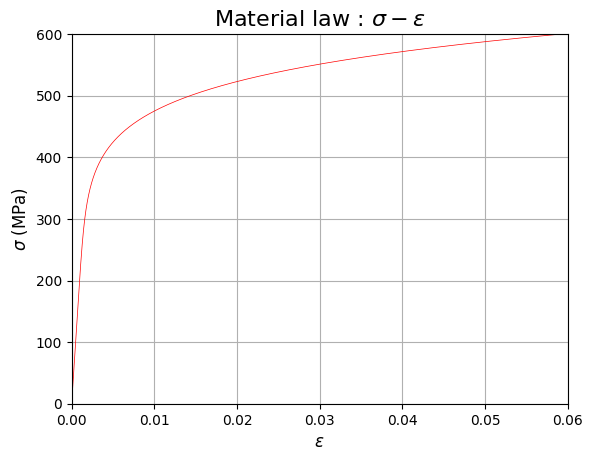

In [7]:
# Material
YoungModulus = 210000.0# MPa
σRambergOsgood = 375.0# MPa σ0 parameter of Ramberg-Osgood material law
Poisson = 0.30#
cRO = 8.5# c parameter of Ramberg-Osgood material law
kRO = 0.58# k parameter of Ramberg-Osgood material law

#plot material law
σstresslist=[]#
εstrainlist=[]#
maxStress=600.#
for σstressIt in range(0,int(maxStress)*10):
  σstresslist.append(σstressIt/10.)#
  εstrainlist.append(σstressIt/10./YoungModulus + kRO*σRambergOsgood/YoungModulus*(σstressIt/10./σRambergOsgood)**cRO)#

maxStrain = np.max(εstrainlist)#
maxStrain = (int(maxStrain/0.01)+1)*0.01#

stressstraincurve = plt.plot(εstrainlist, σstresslist)
plt.setp(stressstraincurve, color='r', linewidth=0.5)

plt.xlabel('$\epsilon$', fontsize=12, color='black')
plt.ylabel('$\sigma$ (MPa)', fontsize=12, color='black')
plt.title('Material law : $\sigma-\epsilon$', fontsize=16, color='black')
plt.axis([0.0, maxStrain, 0., maxStress])
plt.grid(True)
plt.ylim(0, maxStress)
plt.show()

#
# Geometry
dpanel = 1.6*300.0# mm
hw = 300.0# mm
tw= 300.0/10.0# mm
#
plate1=PlateElement( [YoungModulus/σRambergOsgood ,Poisson,cRO,kRO] , dpanel, hw, tw)

Iterative method for the calculation of the buckling stress of the plate element

In [8]:
def FindingBucklingStressesFunc(PlateElem,InitStep, Step,printing=True,tol=0.000001):
    #print("The initial value of λ is ","{:.6f}".format(InitStep))
    λtrial = InitStep
    for jjj in range(0,20,1):
        for iii in range(0,200,1):
            eigvals=np.array(lalgebra.eigh(PlateElem.GetMatrix([0,0,λtrial]))[0])
            numLessZero = 0
            for val in eigvals:
                if(val<0.0):
                    numLessZero=numLessZero+1 #
                  #  print("For cycle ",  iii, " there are ", numLessZero, " eigenvalues less than 0.0 for λ = ", "{:.6f}".format(λtrial), " and for step ", "{:.6f}".format(Step)) #
            if(numLessZero>0):
            #    print(numLessZero, " buckling load is less than ", "{:.6f}".format(λtrial))
                break#
            else:
                λtrial=λtrial+Step#

        if(numLessZero>1): #
            λtrial=λtrial-Step #
            Step=Step/2. #
            λtrial=λtrial+Step #
          #  print(λtrial) #
        else:
            break
    if(numLessZero<1):
        print("Initial Value of λ is too small ")
        return -1
    W2=lalgebra.det(PlateElem.GetMatrix([0,0,λtrial]))
    λtrial=λtrial-Step
    W1=lalgebra.det(PlateElem.GetMatrix([0,0,λtrial]))
    if(math.copysign(1,W2)== math.copysign(1,W1)):
        print("Limit is not OK")
        print("The values of W1 and W2 respectively are ", W1, " and  ", W2)
        return -1
    else:
      if printing:
        print("Limit is OK")
    λmid=0
    for jjj in range(0,100):
        if(Step<tol):
            break
        Step = Step /2
        λmid = λtrial + Step
        λtrial=λmid
        Wmid=lalgebra.det(PlateElem.GetMatrix([0,0,λtrial]))
       # print("λ= ", λmid, " W1= ", W1, " Wmid=", Wmid)
        if(math.copysign(1,W1) != math.copysign(1,Wmid)):
            λtrial = λmid-Step
    if printing:
      print("Buckling coefficient = ", λmid/(math.pi**2))
    return λmid

def formatContourLineTexts(x):
    s = f"{x:.2f}"
    if s.endswith("0"):
        s = f"{x:.2f}"
    #return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def PrintBucklingShape(PlateElem):
  delta = 1./100.#
  ξplot = np.arange(-1., 1.+delta, delta)
  ηplot = np.arange(-1., 1.+delta, delta)
  ResultW1 = []
  Ξplot1 = []
  Ηplot1 = []
  for ξ1 in ξplot:
    for η1 in ηplot:
      Ξplot1.append(ξ1)
      Ηplot1.append(η1)
      ResultW1.append(PlateElem.funcW([ξ1, η1]))
  Ξplot = np.array(Ξplot1)#
  Ηplot = np.array(Ηplot1)#
  ResultW = np.array(ResultW1)#
 # ####
  max1=ResultW.max()
  min1=ResultW.min()
  if max1>-min1:
    abMax = max1
  else:
    abMax = min1
  
  ResultW=ResultW/abMax#
 # ####
  fig, ax = plt.subplots(figsize=(5*PlateElem.dpanel/PlateElem.hw,5))#

  triang = tri.Triangulation(Ξplot, Ηplot)
  CN=ax.tricontour(Ξplot, Ηplot, ResultW, levels=14, linewidths=0.5, colors='k')
  cntr2 = ax.tricontourf(Ξplot, Ηplot, ResultW, levels=14, colors='w')
  ax.clabel(CN, CN.levels, inline=True, fmt=formatContourLineTexts)

  ax.set(xlim=(-1, 1), ylim=(-1, 1))
  ax.set_title('Deformed shape', fontsize=14)
  ax.set_aspect(PlateElem.hw/PlateElem.dpanel)
  ax.set_xlabel(r'$\frac{2x}{d_{panel}}$', fontsize=14)#ax.set_xlabel(r'$\xi$')
  ax.set_ylabel(r'$\frac{2y}{h_{w}}$', fontsize=14)#ax.set_ylabel(r'$\eta$')

  fig2, ax2 = plt.subplots(figsize=(6.2*PlateElem.dpanel/PlateElem.hw,6.2))#

  
  ax2.tricontour(Ξplot, Ηplot, ResultW, levels=14, linewidths=0.5, colors='k')
  cntr22 = ax2.tricontourf(Ξplot, Ηplot, ResultW, levels=14, cmap="RdBu_r")
  fig2.colorbar(cntr22, ax=ax2)

  ax2.set(xlim=(-1, 1), ylim=(-1, 1))
  ax2.set_title('Deformed shape', fontsize=14)
  ax2.set_aspect(PlateElem.hw/PlateElem.dpanel)
  ax2.set_xlabel(r'$\frac{2x}{d_{panel}}$', fontsize=14)#ax.set_xlabel(r'$\xi$')
  ax2.set_ylabel(r'$\frac{2y}{h_{w}}$', fontsize=14)#ax.set_ylabel(r'$\eta$')



def DoCalculations(PlateElem,InitStep, Step,printing=True,tol=0.000001):
  λret = FindingBucklingStressesFunc(PlateElem,InitStep, Step,printing)
  if λret ==-1:
    return
  kbret = λret/(math.pi**2)
  BucklingStress=kbret*(math.pi**2)*YoungModulus/12/(1-Poisson**2)*(hw/tw)**-2# MPa
  PlateElem.GetBucklingCoeff(kbret)#
  if printing:
    print('\nFor the plate element with dimensions : dpanel = ',plate1.dpanel,' mm, hw = ', plate1.hw,
          ' mm and thickness tw = ', plate1.tw, '. Under pure shear thrusts\nthe buckling coefficient is ', "{:.6f}".format(kbret),
          'and the corresponding buckling stress is τcr = ',"{:.2f}".format(BucklingStress),'MPa.\n')
    PrintBucklingShape(PlateElem)

  return kbret, BucklingStress

Limit is OK
Buckling coefficient =  0.19292682901279457

For the plate element with dimensions : dpanel =  480.0  mm, hw =  300.0  mm and thickness tw =  30.0 . Under pure shear thrusts
the buckling coefficient is  0.192927 and the corresponding buckling stress is τcr =  366.18 MPa.



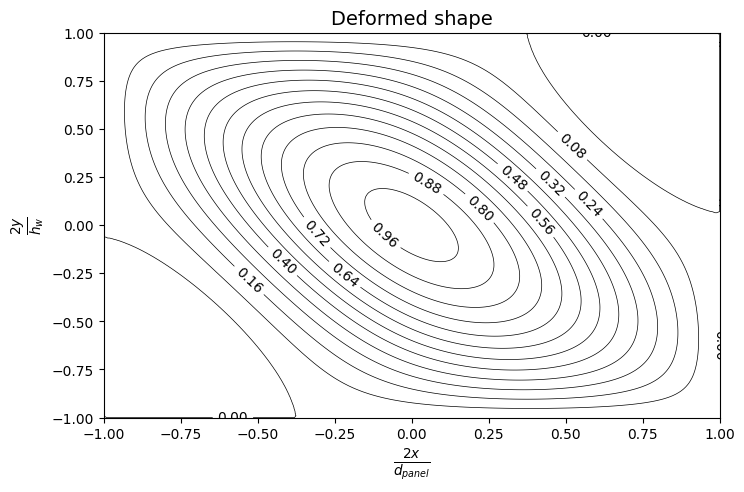

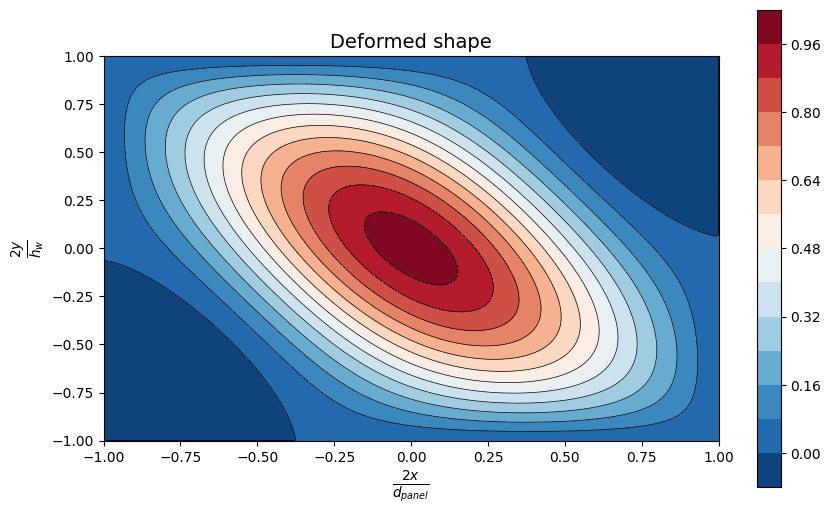

In [9]:
retvals = DoCalculations(plate1,1, 0.1)
#retvals = DoCalculations(plate1,10., 10.)

Batch run

In [10]:
# Material
YoungModulus = 210000.0# MPa
σRambergOsgood = 375.0# MPa σ0 parameter of Ramberg-Osgood material law
Poisson = 0.30#
cRO = 8.5# c parameter of Ramberg-Osgood material law
kRO = 0.58# k parameter of Ramberg-Osgood material law
#
# Geometry
hw = 500.0# mm

dpanelhwMin = 0.20#
dpanelhwMax = 2.00#
dpanelhwStep = 0.10#

hwtwMin= 30.#
hwtwMax= 55.#
hwtwStep= 5.#

PlateElementList = []
BucklingCoeffResultList = []

for hwtwIter in np.arange(hwtwMin, hwtwMax+hwtwStep, hwtwStep):
  for dpanelhwIter in np.arange(dpanelhwMin, dpanelhwMax+dpanelhwStep, dpanelhwStep):
    PlateElementList.append(PlateElement( [YoungModulus/σRambergOsgood ,Poisson,cRO,kRO] , dpanelhwIter*hw, hw, hw/hwtwIter))
#
intiter=0
for PlateIter in PlateElementList:
  intiter=intiter+1
  print('No:',intiter)
  #print('dpanel/hw :',PlateIter.ζ,' hw/tw :',1/PlateIter.τ)
  BucklingCoeffResultList.append([PlateIter.ζ,1/PlateIter.τ,DoCalculations(PlateIter,10., 10.,False)[0]])

No: 1
No: 2
No: 3
No: 4
No: 5
No: 6
No: 7
No: 8
No: 9
No: 10
No: 11
No: 12
No: 13
No: 14
No: 15
No: 16
No: 17
No: 18
No: 19
No: 20
No: 21
No: 22
No: 23
No: 24
No: 25
No: 26
No: 27
No: 28
No: 29
No: 30
No: 31
No: 32
No: 33
No: 34
No: 35
No: 36
No: 37
No: 38
No: 39
No: 40
No: 41
No: 42
No: 43
No: 44
No: 45
No: 46
No: 47
No: 48
No: 49
No: 50
No: 51
No: 52
No: 53
No: 54
No: 55
No: 56
No: 57
No: 58
No: 59
No: 60
No: 61
No: 62
No: 63
No: 64
No: 65
No: 66
No: 67
No: 68
No: 69
No: 70
No: 71
No: 72
No: 73
No: 74
No: 75
No: 76
No: 77
No: 78
No: 79
No: 80
No: 81
No: 82
No: 83
No: 84
No: 85
No: 86
No: 87
No: 88
No: 89
No: 90
No: 91
No: 92
No: 93
No: 94
No: 95
No: 96
No: 97
No: 98
No: 99
No: 100
No: 101
No: 102
No: 103
No: 104
No: 105
No: 106
No: 107
No: 108
No: 109
No: 110
No: 111
No: 112
No: 113
No: 114


In [11]:
print("dpanel/hw    hw/tw \t Plate buckling coefficient")
print("                   \t      under pure shear\n")
for iter1 in BucklingCoeffResultList:
  print("{:7.3f}".format(iter1[0]),'    ',"{:5.2f}".format(iter1[1]),"{:22.6f}".format(iter1[2]))

dpanel/hw    hw/tw 	 Plate buckling coefficient
                   	      under pure shear

  0.200      30.00               1.879156
  0.300      30.00               1.742140
  0.400      30.00               1.643146
  0.500      30.00               1.572323
  0.600      30.00               1.515417
  0.700      30.00               1.463363
  0.800      30.00               1.423206
  0.900      30.00               1.392841
  1.000      30.00               1.370264
  1.100      30.00               1.353764
  1.200      30.00               1.341925
  1.300      30.00               1.333601
  1.400      30.00               1.327877
  1.500      30.00               1.324031
  1.600      30.00               1.321488
  1.700      30.00               1.319787
  1.800      30.00               1.318553
  1.900      30.00               1.313698
  2.000      30.00               1.308464
  0.200      35.00               2.486037
  0.300      35.00               2.294114
  0.400      35.00        

In [12]:
# Geometry 2
hwtwMin= 10.#
hwtwMax= 25.#
hwtwStep= 5.#

PlateElementList2 = []
BucklingCoeffResultList2 = []

for hwtwIter in np.arange(hwtwMin, hwtwMax+hwtwStep, hwtwStep):
  for dpanelhwIter in np.arange(dpanelhwMin, dpanelhwMax+dpanelhwStep, dpanelhwStep):
    PlateElementList2.append(PlateElement( [YoungModulus/σRambergOsgood ,Poisson,cRO,kRO] , dpanelhwIter*hw, hw, hw/hwtwIter))
#
intiter=0
for PlateIter in PlateElementList2:
  intiter=intiter+1
  print('No:',intiter)
  #print('dpanel/hw :',PlateIter.ζ,' hw/tw :',1/PlateIter.τ)
  BucklingCoeffResultList2.append([PlateIter.ζ,1/PlateIter.τ,DoCalculations(PlateIter,1., 0.2,False)[0]])

No: 1
No: 2
No: 3
No: 4
No: 5
No: 6
No: 7
No: 8
No: 9
No: 10
No: 11
No: 12
No: 13
No: 14
No: 15
No: 16
No: 17
No: 18
No: 19
No: 20
No: 21
No: 22
No: 23
No: 24
No: 25
No: 26
No: 27
No: 28
No: 29
No: 30
No: 31
No: 32
No: 33
No: 34
No: 35
No: 36
No: 37
No: 38
No: 39
No: 40
No: 41
No: 42
No: 43
No: 44
No: 45
No: 46
No: 47
No: 48
No: 49
No: 50
No: 51
No: 52
No: 53
No: 54
No: 55
No: 56
No: 57
No: 58
No: 59
No: 60
No: 61
No: 62
No: 63
No: 64
No: 65
No: 66
No: 67
No: 68
No: 69
No: 70
No: 71
No: 72
No: 73
No: 74
No: 75
No: 76


In [13]:
print("dpanel/hw    hw/tw \t Plate buckling coefficient")
print("                   \t      under pure shear\n")
for iter1 in BucklingCoeffResultList2:
  print("{:7.3f}".format(iter1[0]),'    ',"{:5.2f}".format(iter1[1]),"{:22.6f}".format(iter1[2]))

dpanel/hw    hw/tw 	 Plate buckling coefficient
                   	      under pure shear

  0.200      10.00               0.235364
  0.300      10.00               0.229453
  0.400      10.00               0.223224
  0.500      10.00               0.217229
  0.600      10.00               0.212575
  0.700      10.00               0.207436
  0.800      10.00               0.203333
  0.900      10.00               0.200200
  1.000      10.00               0.197870
  1.100      10.00               0.196174
  1.200      10.00               0.194965
  1.300      10.00               0.194123
  1.400      10.00               0.193551
  1.500      10.00               0.193173
  1.600      10.00               0.192927
  1.700      10.00               0.192763
  1.800      10.00               0.192599
  1.900      10.00               0.191955
  2.000      10.00               0.191429
  0.200      15.00               0.515971
  0.300      15.00               0.492946
  0.400      15.00        